In [1]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import gensim
from gensim.models import Word2Vec, FastText, KeyedVectors
%matplotlib inline

In [48]:
import tensorflow 


from keras import layers,optimizers, regularizers

from keras.models import Sequential, Model

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot, Tokenizer

from keras.metrics import categorical_accuracy
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.backend import mean

from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten, multiply, Lambda
from keras.layers import MaxPooling1D, Embedding, Bidirectional, CuDNNLSTM, RepeatVector
from keras.layers import MaxPooling2D, concatenate, SpatialDropout1D

from keras.layers.core import Reshape, Flatten, Permute
from keras.layers.normalization import BatchNormalization

from keras.callbacks import EarlyStopping

In [3]:
fasttext =  KeyedVectors.load_word2vec_format('../WordEmbeddings/FastText/cc.de.300.vec') 

#Load pretrained FastText
#model_ft =  KeyedVectors.load_word2vec_format('../WordEmbeddings/FastText/cc.de.300.vec') 

#Load domain specific FastText
#model_ds_ft = FastText.load("../WordEmbeddings/ft_ds.model")

#Load domain specific word2vec
#model_ds_w2v = Word2Vec.load("../WordEmbeddings/w2v_ds.model")


In [5]:
test_data = pd.read_pickle("../Data/testset.pkl")
train_data = pd.read_pickle("../Data/trainset.pkl")

train_data=train_data[train_data.label!="A"]
test_data=test_data[test_data.label!="A"]

vocab_base = pd.concat([train_data, test_data])

In [7]:
NUM_WORDS=20000
tokenizer = Tokenizer(num_words=NUM_WORDS,
                      lower=True)
tokenizer.fit_on_texts(vocab_base.CR_s)
sequences_train = tokenizer.texts_to_sequences(train_data.CR_s)
sequences_test = tokenizer.texts_to_sequences(test_data.CR_s)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 36785 unique tokens.


In [8]:
functions=train_data.label.unique()
dic={}
for i,func in enumerate(functions):
    dic[func]=i
train_labels=train_data.label.apply(lambda x:dic[x])
test_labels = test_data.label.apply(lambda x:dic[x])

In [9]:
X_train = pad_sequences(sequences_train)
y_train = to_categorical(np.asarray(train_labels[train_data.index]))

X_test = pad_sequences(sequences_test,maxlen=X_train.shape[1])
y_test = to_categorical(np.asarray(test_labels[test_data.index]))
print('Shape of X_train and X_test tensor:', X_train.shape, X_test.shape)
print('Shape of label train and test tensor:', y_train.shape, y_test.shape)

Shape of X_train and X_test tensor: (7556, 405) (841, 405)
Shape of label train and test tensor: (7556, 8) (841, 8)


In [10]:
#Hier kann man zwischen den Embeddings umschalten!
embed=fasttext

pretrained_weights = embed.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [11]:
# Alternaticve Möglichkeit mit keras-Bordmitteln???
# https://stackoverflow.com/questions/51492778/how-to-properly-use-get-keras-embedding-in-gensim-s-word2vec

MAX_NB_WORDS = len(word_index)
EMBEDDING_DIM = emdedding_size
nb_words = len(word_index)+1
# we initialize the matrix with random numbers
ft_matrix = (np.random.rand(nb_words, EMBEDDING_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = embed.wv[word]
        # words not found in embedding index will be all-zeros.
        ft_matrix[i] = embedding_vector
    except:
        pass        

In [31]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_data.label),
                                                 train_data.label)
print(class_weights)

# Run this with test_data and compare!

class_weights_test = class_weight.compute_class_weight('balanced',
                                                 np.unique(test_data.label),
                                                 test_data.label)
print(class_weights_test)

# Wäre noch eine Baustelle, hier nochmal zu mergen und durchzumischen. 
# Aber so in erster Näherung ok... 

[ 0.59216301  3.02724359  2.04437229  5.72424242  0.363409   10.15591398
  9.35148515  0.42373262]
[ 0.54468912  3.18560606  2.14540816  4.38020833  0.38507326 17.52083333
 13.140625    0.4122549 ]


In [63]:
# Source: Modified version of:  https://github.com/philipperemy/keras-attention-mechanism

SINGLE_ATTENTION_VECTOR = False

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs) #Dense layer operates only on last dimension of array. hence we rotate time in last place
    a = Dense(405, activation='softmax')(a) #Weights are the attention matrix: 405 x 405 
    if SINGLE_ATTENTION_VECTOR: #if single layer, then take mean over all hidden dimensions, then broadcast mean back over hidden dimensiosn
        a = Lambda(lambda x: mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a) #permute time back in second place, hidden dimensions back to last
    # output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

In [64]:
vocab_size = len(tokenizer.word_index) + 1
input_dim = X_train.shape[1]  # length padded sequences

inputs = Input(name='inputs',shape=[input_dim])
layer = Embedding(input_dim=vocab_size, 
                            output_dim=EMBEDDING_DIM, 
                            weights=[ft_matrix],
                            trainable=False)(inputs)
lstm_out = LSTM(100,dropout=0.2,recurrent_dropout=0.2, return_sequences=True)(layer)
lstm_out = Dropout(0.2)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
attention_mul = Flatten()(attention_mul)
output = Dense(len(functions), activation='softmax')(attention_mul)


model = Model(input=[inputs], output=output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  app.launch_new_instance()


In [65]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 405)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 405, 300)     11035800    inputs[0][0]                     
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 405, 100)     160400      embedding_9[0][0]                
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 405, 100)     0           lstm_9[0][0]                     
____________________________________________________________________________________________

In [67]:
history = model.fit(X_train, y_train,
                    validation_split=0,
                    validation_data=(X_test, y_test),
                    epochs=50, 
                    batch_size=16,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)], 
                    shuffle=True,
                    class_weight=class_weights
                   )

Train on 7556 samples, validate on 841 samples
Epoch 1/50
7556/7556 [==============================] - 124s 16ms/step - loss: 0.7584 - accuracy: 0.7233 - val_loss: 0.7558 - val_accuracy: 0.7229
Epoch 2/50
7556/7556 [==============================] - 125s 17ms/step - loss: 0.7337 - accuracy: 0.7336 - val_loss: 0.7243 - val_accuracy: 0.7432
Epoch 3/50
7556/7556 [==============================] - 124s 16ms/step - loss: 0.7013 - accuracy: 0.7458 - val_loss: 0.7056 - val_accuracy: 0.7455
Epoch 4/50
7556/7556 [==============================] - 124s 16ms/step - loss: 0.6869 - accuracy: 0.7524 - val_loss: 0.6854 - val_accuracy: 0.7574
Epoch 5/50
7556/7556 [==============================] - 124s 16ms/step - loss: 0.6593 - accuracy: 0.7680 - val_loss: 0.6771 - val_accuracy: 0.7646
Epoch 6/50
7556/7556 [==============================] - 125s 17ms/step - loss: 0.6379 - accuracy: 0.7767 - val_loss: 0.6817 - val_accuracy: 0.7574
Epoch 7/50
7556/7556 [==============================] - 126s 17ms/step 

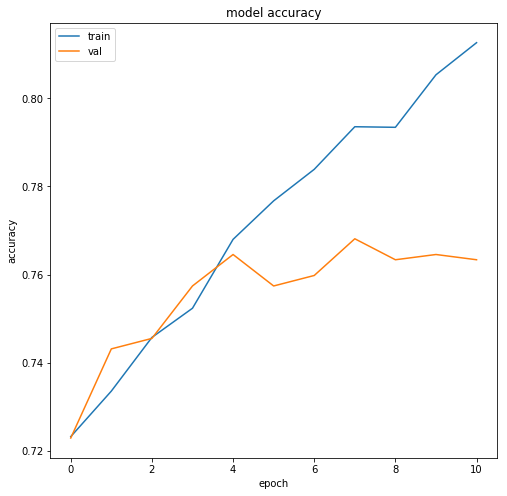

In [68]:
plt.figure(figsize=(8,8));
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

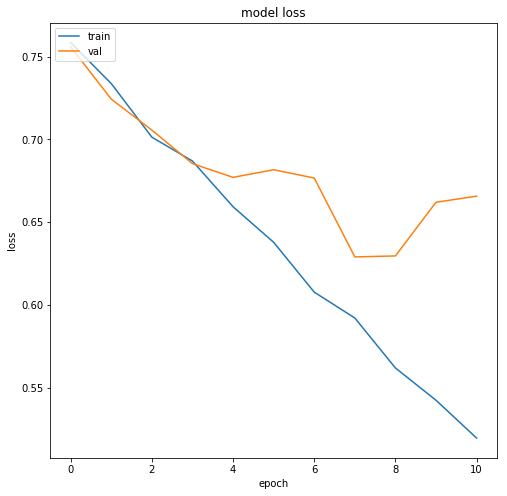

In [69]:
plt.figure(figsize=(8,8));
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
print(model.evaluate(X_test,y_test))
print(model.metrics_names)

841/841 [==============================] - 2s 3ms/step
[0.6657182054769128, 0.7633769512176514]
['loss', 'accuracy']


In [56]:
for layer in model.layers: print(layer.get_config(), layer.get_weights())

{'batch_input_shape': (None, 405), 'dtype': 'float32', 'sparse': False, 'name': 'inputs'} []
{'name': 'embedding_6', 'trainable': False, 'batch_input_shape': (None, None), 'dtype': 'float32', 'input_dim': 36786, 'output_dim': 300, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': None} [array([[-0.06219178,  0.01851014, -0.03526384, ..., -0.07026948,
        -0.03989571, -0.02812475],
       [ 0.0357    ,  0.0152    ,  0.0626    , ...,  0.0103    ,
        -0.0027    , -0.0119    ],
       [-0.0181    , -0.0035    ,  0.0374    , ..., -0.0009    ,
        -0.004     , -0.0159    ],
       ...,
       [-0.02117594,  0.06782613, -0.0423121 , ...,  0.04121714,
         0.05288602, -0.08463021],
       [-0.06492188, -0.07552168, -0.09243724, ..., -0.00352561,
         0.02750216, -0.07809304],
   

In [59]:
dense_7.get_weights()

NameError: name 'dense_7' is not defined